# Made with ML

- https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb
- https://madewithml.com/

In [1]:
# import os
# import sys
# import time
# import numpy as np
# import pandas as pd
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# import seaborn as sns
# from scipy import stats
# import warnings; warnings.filterwarnings('ignore')
# #plt.style.use('ggplot')
# plt.style.use('seaborn-whitegrid')
# %matplotlib inline

# 3. Model
## 3.1 Distributed training

### Intuition

이제 데이터가 준비되었으므로 목표에 맞게 최적화하기 위한 모델 훈련을 시작할 수 있습니다.  
가능한 가장 단순한 기준선에서 시작하여 천천히 모델에 복잡성을 추가하는 것이 이상적입니다:

1. 무작위(확률) 모델로 시작합니다.
- 클래스가 4개이므로 무작위 모델이 25% 정도는 맞을 것으로 예상할 수 있지만, 모든 클래스의 개수가 같지는 않다는 점을 기억하세요.

2. if-else 문, 정규식 등을 사용하여 규칙 기반 접근 방식을 개발합니다.
- 각 클래스에 대한 공통 단어 목록을 작성하고 입력된 단어가 목록에 있는 단어와 일치하면 해당 클래스를 예측할 수 있습니다.

3. 제한 사항을 해결하고 표현과 모델 아키텍처에 동기를 부여하여 복잡성을 서서히 추가하세요.
- 간단한 용어 빈도(TF-IDF) 모드로 시작한 다음 CNN, RNN, 트랜스포머 등을 사용한 임베딩으로 이동할 수 있습니다.

4. 성능 기준선 간의 트레이드오프(성능, 지연 시간, 크기 등)를 평가합니다.
- 데이터 세트가 커지고 새로운 모델 아키텍처가 개발됨에 따라 기준선을 재검토하고 반복합니다.
복잡한 모델을 개발하는 3단계는 바로 건너뛰겠습니다. 이 작업에는 구조화되지 않은 데이터가 포함되며 규칙 기반 시스템은 이에 적합하지 않기 때문입니다. 그리고 NLP 작업을 위한 입증된 모델 아키텍처로 대규모 언어 모델(LLM)의 채택이 증가함에 따라 데이터 세트에 대해 사전 학습된 LLM을 미세 조정할 것입니다.

Iterate on the data   

고정된 데이터 집합을 사용하고 모델을 반복하는 대신, 모델을 일정하게 유지하고 데이터 집합을 반복할 수 있습니다.  
이는 데이터 세트의 품질을 개선하는 데 유용합니다.

- 데이터 샘플 제거 또는 수정(오탐 및 미탐)
- 기능 준비 및 변환
- 클래스 확장 또는 통합
- 보조 데이터 세트 통합
- 부스트할 고유 슬라이스 식별

### Distributed training

데이터(비정형)와 모델 크기(예: LLM)가 급격히 증가함에 따라 단일 머신에서 모델을 학습시키는 것이 점점 더 어려워지고 있습니다. 합리적인 시간 내에 모델을 학습시키려면 여러 머신에 학습을 분산시킬 수 있어야 합니다. 그리고 우리는 이를 손쉽게 수행할 수 있기를 원합니다:   


- 컴퓨팅 리소스(CPU, GPU 등)를 개별적으로 (그리고 힘들게) 프로비저닝하여 클러스터를 설정합니다.  
- 여러 머신에 트레이닝을 분산하기 위해 복잡한 코드를 작성할 필요가 없습니다.  
- 서로 다른 분산 컴퓨팅 리소스 간의 통신 및 리소스 활용에 대한 걱정  
- 대규모 훈련 워크로드에서 발생하는 내결함성 및 복구에 대한 걱정  
 
이러한 모든 문제를 해결하기 위해 여기서는 레이 트레인을 사용하여 여러 머신에 걸쳐 확장할 수 있는 트레이닝 워크플로를 만들 것입니다. 분산 트레이닝을 위해 선택할 수 있는 옵션은 Pytorch 분산 데이터 병렬(DDP), Horovod 등 여러 가지가 있지만, 레이처럼 단일 머신 트레이닝 코드의 변경을 최소화하면서 여러 머신에 걸쳐 쉽게 확장할 수 있는 솔루션은 없습니다.


분산 트레이닝에 대한 입문서  

분산 학습에서는 학습 프로세스를 조율하는 헤드 노드가 있습니다. 반면 워커 노드는 모델을 훈련하고 결과를 헤드 노드에 전달하는 역할을 담당합니다.  
사용자 관점에서 보면, Ray는 이러한 모든 복잡성을 추상화하여 마치 단일 머신에서 트레이닝하는 것처럼 최소한의 코드 변경만으로 트레이닝 기능을 간단하게 정의할 수 있습니다.

### Generative AI

이 단원에서는 레이블이 지정된 데이터 세트를 사용하여 사전 학습된 대규모 언어 모델(LLM)을 미세 조정해 보겠습니다.  
우리가 사용할 특정 클래스의 LLM을 BERT라고 합니다.  
BERT 모델은 인코더 전용 모델이며 지도형 NLP 작업에 가장 적합한 표준입니다.  
하지만 제너레이티브 애플리케이션용으로 만들어진 (훨씬 더 큰) LLM(GPT 4, Falcon 40B, Llama 2 등)은 어떻게 작동하는지 궁금할 수 있습니다.

저희는 훈련과 미세 조정이 더 쉽기 때문에 더 작은 BERT 모델을 코스에 선택했습니다.  
하지만 더 큰 LLM을 미세 조정하는 워크플로도 매우 유사합니다.  
훨씬 더 많은 연산이 필요하지만 Ray는 이와 관련된 스케일링의 복잡성을 추상화합니다.

--- 생략----  
추후 해볼 것

### Setup

이제 라이브러러리를 정의하고 우리 모델을 설정해보자.

In [2]:
import os
import random
import torch
import torch.nn as nn
from ray.data.preprocessor import Preprocessor
from transformers import BertTokenizer
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [3]:
import numpy as np

In [4]:
# Label to index
tags = ['mlops', 'natural-language-processing', 'computer-vision', 'other']
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [5]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sguys99/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

In [7]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [8]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [9]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

라이브러리 전체에 걸쳐 재현성을 위한 시드를 설정하는 set_seeds 함수를 정의할 것입니다(np.random.seed, random.seed, torch.manual_seed 및 torch.cuda.manual_seed).  
또한 GPU에서 워크로드를 실행할 때 결정론적 결과를 보장하기 위해 일부 토치 백엔드에 대한 동작을 설정할 것입니다.

In [10]:
def set_seeds(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [11]:
import ray

# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-12-19 08:39:45,477	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [12]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
# df = pd.read_csv(DATASET_LOC)
# df.head()

다음으로, 소스(CSV 파일)에서 데이터를 수집하고 이를 레이 데이터 세트로 로드하는 간단한 load_data 함수를 정의하겠습니다.

In [13]:
def load_data(num_samples = None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_suffle(seed = 1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

매우 큰 데이터 세트로 작업할 때는 코드를 빠르게 실행하고 버그 등을 반복할 수 있도록 데이터 세트의 샘플 수를 제한하는 것이 좋습니다. 
이것이 바로 load_data 함수에 num_samples 입력 인수가 있는 이유입니다(None = 제한 없음, 모든 샘플).

또한 데이터 세트를 편리하게 전처리하고 나중에 저장/로드하기 위해 사용할 사용자 정의 전처리기 클래스를 정의하겠습니다.  

전처리기를 정의할 때, 데이터 세트에 맞추는 방법을 학습하기 위한 _fit 메서드와 _fit 메서드의 구성 요소를 사용해 데이터 세트를 전처리하기 위한 _transform_{pandas|numpy} 메서드를 정의해야 합니다.  
전처리를 판다스 데이터프레임에 적용하기 위해 _transform_pandas 메서드를 정의하거나, 전처리를 NumPy 배열에 적용하기 위해 _transform_numpy 메서드를 정의할 수 있습니다.  
여기서는 전처리 함수가 데이터 배치를 Pandas 데이터 프레임으로 예상하므로 _transform_pandas 메서드를 정의하겠습니다.

In [14]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

#### Model

이제 모델 아키텍처를 정의할 준비가 되었습니다. 먼저 사전 학습된 LLM을 로드한 다음 데이터 세트에서 미세 조정하는 데 필요한 구성 요소를 정의하겠습니다. 여기서 말하는 사전 학습된 LLM은 scibert라는 대규모 과학 텍스트 코퍼스에 대해 사전 학습된 트랜스포머 기반 모델입니다.

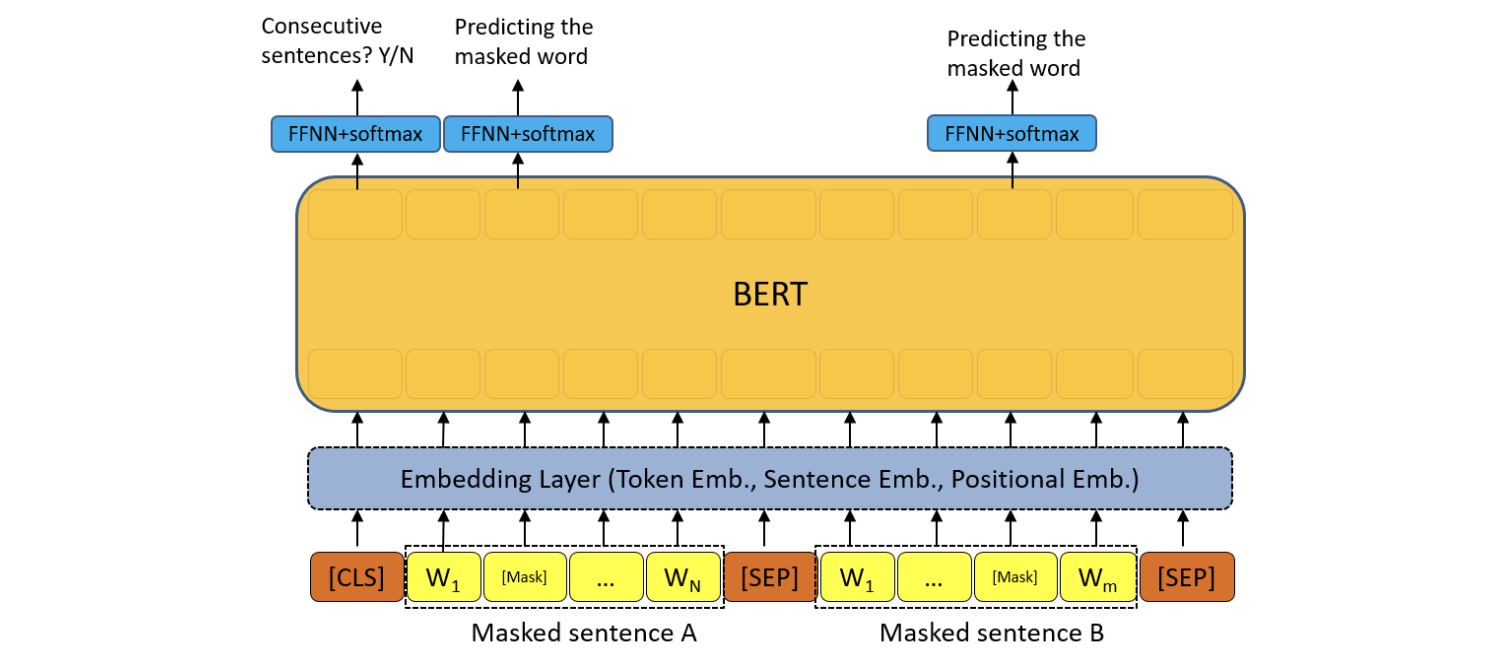

In [15]:
import torch.nn as nn
from transformers import BertModel

In [16]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
embedding_dim

768

모델이 로드되면 입력 텍스트를 토큰화하여 토치 텐서로 변환한 후 모델을 통과시켜 텍스트의 시퀀스와 풀링된 표현을 얻을 수 있습니다.

In [18]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")

In [19]:
batch

{'input_ids': array([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,
          103]]), 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
batch

{'input_ids': tensor([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,   103]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [21]:
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

이 사전 학습된 모델을 사용해 입력 텍스트의 특징을 표현하고 그 위에 특정 분류 작업을 위한 추가 레이어(선형 분류기)를 추가하겠습니다.   
간단히 말해, 사전 학습된 LLM은 토큰화된 텍스트를 처리하고 텍스트의 시퀀스(각 토큰 뒤에 하나의 표현)와 풀링된(결합된) 표현을 반환합니다. 풀링된 표현을 최종 완전 연결 계층(fc1)의 입력으로 사용하여 예측에 사용할 수 있는 num_classes(클래스 수) 크기의 벡터를 생성합니다.

In [22]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

모델 초기화

In [23]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

#### Batching

데이터 집합을 일괄적으로 반복할 수 있지만 크기가 다른 배치가 있을 수 있습니다.  
토큰화 도구가 배치에서 가장 긴 항목에 입력을 패딩했다는 점을 기억하세요(패딩="가장 긴").  
그러나 학습용 배치는 대규모 데이터 처리 배치보다 작을 것이므로 여기서의 배치에는 길이가 다른 입력이 있을 수 있습니다.  
이 문제를 해결하기 위해 사용자 정의 collate_fn을 정의하여 훈련 배치의 항목을 다시 패딩하겠습니다.

In [24]:
from ray.train.torch import get_device

pad_array 함수는 배열 배열을 받아 내부 배열을 가장 긴 길이로 채웁니다.

In [25]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
        
    return padded_arr

그리고 collate_fn은 데이터 배치를 가져와서 데이터를 채우고 적절한 PyTorch 텐서 유형으로 변환합니다.

In [26]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

데이터 세트의 샘플 배치에서 collate_fn을 테스트해 보겠습니다.

In [27]:
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import ray
from ray.data import Dataset
from sklearn.model_selection import train_test_split

def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:
    """Split a dataset into train and test splits with equal
    amounts of data points from each class in the column we
    want to stratify on.

    Args:
        ds (Dataset): Input dataset to split.
        stratify (str): Name of column to split on.
        test_size (float): Proportion of dataset to split for test set.
        shuffle (bool, optional): whether to shuffle the dataset. Defaults to True.
        seed (int, optional): seed for shuffling. Defaults to 1234.

    Returns:
        Tuple[Dataset, Dataset]: the stratified train and test datasets.
    """

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

In [28]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed = 1234)

# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-12-19 08:39:48,721	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2023-12-19 08:39:48,732	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-12-19 08:39:48,732	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-12-19 08:39:48,733	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")

In [30]:
sample_ds

MapBatches(preprocess)
+- RandomShuffle
   +- MapBatches(_filter_split)
      +- MapBatches(group_fn)
         +- Sort
            +- RandomShuffle
               +- Dataset(
                     num_blocks=20,
                     num_rows=764,
                     schema={
                        id: int64,
                        created_on: timestamp[s],
                        title: string,
                        description: string,
                        tag: string
                     }
                  )

In [31]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2023-12-19 08:39:50,226	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2023-12-19 08:39:50,227	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-19 08:39:50,227	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_33902/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())


{'ids': tensor([[  102,  6121,  2216,  ..., 15308, 10288,   103],
         [  102, 19015,   318,  ...,     0,     0,     0],
         [  102,   405,  4920,  ...,     0,     0,     0],
         ...,
         [  102,  3267,  4576,  ...,     0,     0,     0],
         [  102,  4686,  5329,  ...,     0,     0,     0],
         [  102,   239, 30118,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([2, 2, 2, 2, 3, 2, 2, 1, 0, 0, 1, 3, 2, 2, 3, 1, 1, 3, 2, 1, 3, 2, 2, 1,
         1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 0, 0, 1, 3, 2, 2, 3,
         1, 1, 3, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 3, 2,
         2, 1, 0, 0, 1, 3, 2, 2, 3, 1, 1, 3, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 0,
         1, 2, 

#### Utilities

다음으로 분산 학습에 필요한 유틸리티 함수 세트를 구현해 보겠습니다.

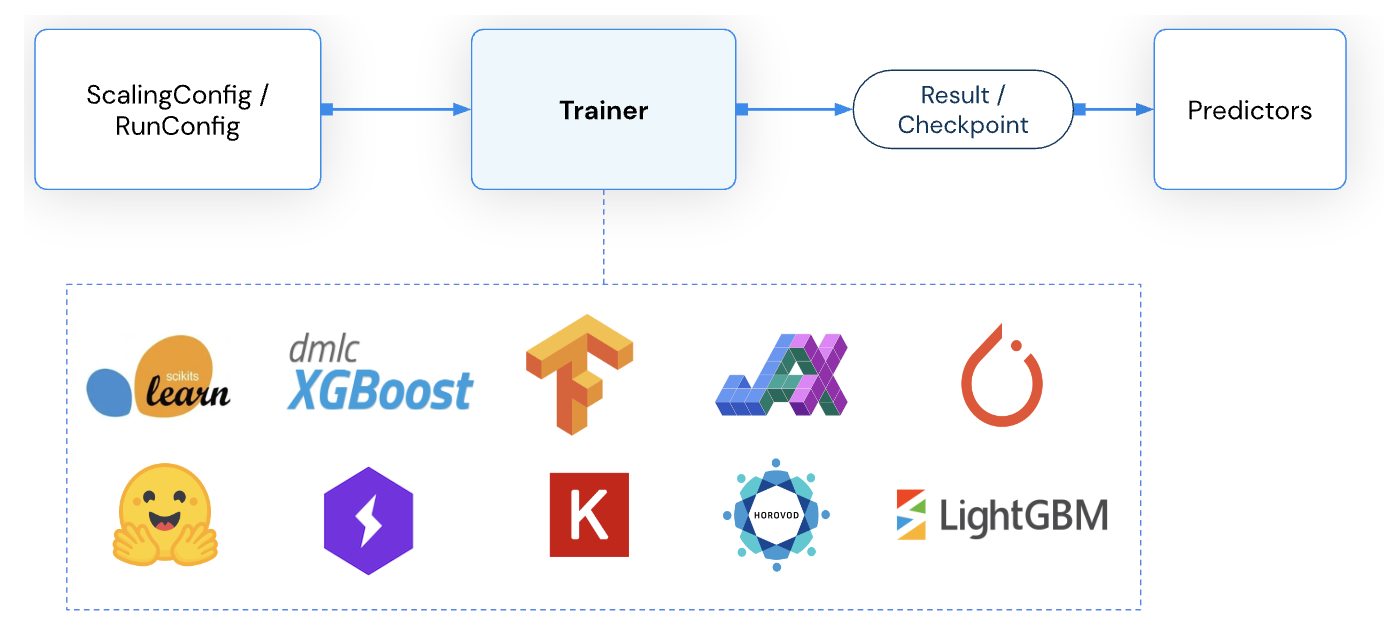

In [32]:
from ray.air import Checkpoint, session
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

먼저 학습의 한 단계(또는 반복)가 어떤 모습인지 정의하는 것부터 시작하겠습니다.  
이 함수는 데이터, 모델, 손실 함수, 최적화 함수를 일괄적으로 받아들이는 함수가 될 것입니다.  
그런 다음 포워드 패스를 수행하여 손실을 계산하고 백워드 패스를 수행하여 모델의 가중치를 업데이트합니다.  
마지막으로 손실을 반환합니다.

In [33]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()
        z = model(batch)
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()
        J = loss_fn(z, targets)
        J.backward()
        optimizer.step()
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

참고: 데이터 배치를 생성하는 제너레이터를 생성하기 위해 torch.utils.data.DataLoader 대신 ray.data.iter_torch_batches 메서드를 사용하고 있습니다. 사실 이것은 일반적인 PyTorch 트레이닝 루프와 다른 유일한 라인이며 실제 트레이닝 워크플로는 그대로 유지됩니다. Ray는 다양한 프레임워크에 대한 데이터를 로드/소비하는 다른 많은 방법도 지원합니다.

유효성 검사 단계는 훈련 단계와 매우 유사하지만 백워드 패스를 수행하거나 모델의 가중치를 업데이트할 필요가 없습니다.

In [34]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

다음으로, 각 워커에 대한 전체 학습 루프를 정의하는 train_loop_per_worker를 정의하겠습니다.  
데이터 세트, 모델 등의 로딩과 같은 작업을 포함시켜 각 워커가 이러한 객체의 자체 복사본을 갖도록 하는 것이 중요합니다.   레이는 각 반복이 끝날 때마다 모든 워커의 결과를 결합하는 작업을 처리하므로 사용자 입장에서는 단일 머신에서 훈련하는 것과 똑같습니다!  

일반적인 PyTorch 트레이닝 루프와 비교하여 추가해야 하는 유일한 코드 줄은 다음과 같습니다:  

- 데이터 스플릿을 로드하기 위한 
    - session.get_dataset_shard("train") 및 session.get_dataset_shard("val")(session.get_dataset_shard).
- model = train.torch.prepare_model(model)을 호출하여 분산 실행을 위한 토치 모델을 준비(train.torch.prepare_model).
- batch_size_per_worker = batch_size // session.get_world_size()로 각 워커의 배치 크기를 조정합니다(session.get_world_size).
- session.report(metrics, checkpoint=checkpoint)를 사용하여 메트릭을 보고하고 모델 체크포인트를 저장합니다(session.report).   

다른 모든 코드 줄은 일반적인 PyTorch 트레이닝 루프와 동일합니다!

In [35]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = session.get_dataset_shard("train")
    val_ds = session.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // session.get_world_size()
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        checkpoint = TorchCheckpoint.from_model(model=model)
        session.report(metrics, checkpoint=checkpoint)

참고 클래스 불균형   
- 우리 데이터 세트에는 심각한 클래스 불균형이 존재하지 않지만, 만약 존재한다면 손실 함수를 통해 이를 쉽게 해결할 수 있습니다.  
- 자주 사용하지 않는 클래스를 오버샘플링하고 인기 있는 클래스를 언더샘플링하는 등의 다른 전략도 있습니다.   


```python
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```

#### Configurations

In [36]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

다음으로 트레이닝 워크로드를 확장하는 방법을 지정하는 스케일링 구성(ScalingConfig)을 정의하겠습니다.   
작업자 수(num_workers), GPU 사용 여부(use_gpu), 작업자당 리소스(resources_per_worker) 및 각 작업자가 사용할 수 있는 CPU의 양(_max_cpu_fraction_per_node)을 지정합니다.

In [37]:
ray.cluster_resources()

{'memory': 29986039399.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 2147483648.0,
 'CPU': 10.0,
 'node:__internal_head__': 1.0}

In [38]:
num_workers = 6  # prefer to do a few less than total available CPU (1 for head node + 1 for background tasks)
resources_per_worker={"CPU": 1, "GPU": 0}

In [39]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
    #_max_cpu_fraction_per_node=0.8,
)

다음으로, 모델을 체크포인트하는 방법을 지정하는 CheckpointConfig를 정의하겠습니다. 여기서는 최소값 밸_손실이 있는 체크포인트를 기준으로 하나의 체크포인트(num_to_keep)만 저장하겠습니다. 또한 런의 이름과 체크포인트를 저장할 위치를 지정하는 RunConfig를 구성할 것입니다.

In [40]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="~/ray_results")

실험의 이름을 llm으로 지정하고 결과를 ~/ray_results에 저장할 것이므로 학습된 모델의 샘플 디렉토리 구조는 다음과 같습니다:

```
/home/ray/ray_results/llm
├── TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
├── basic-variant-state-2023-07-20_18-14-50.json
├── experiment_state-2023-07-20_18-14-50.json
├── trainer.pkl
└── tuner.pkl

```

TorchTrainer_ 객체는 이 실험에서 실행되는 개별 객체이며 각 객체는 다음과 같은 내용을 갖습니다:

```
/home/ray/ray_results/TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
├── checkpoint_000009/  # we only save one checkpoint (the best)
├── events.out.tfevents.1689902160.ip-10-0-49-200
├── params.json
├── params.pkl
├── progress.csv
└── result.json
```

레이로 설정할 수 있는 몇 가지 다른 구성(예: 장애 처리)이 있으므로 여기에서 확인해 보세요.

stopping criteria   

실험을 일정 시간 동안 실행한 후 자동으로 중지하도록 할 수도 있지만, RunConfig는 트레이닝을 중지해야 하는 조건을 결정하는 선택적 중지 기준(중지)을 허용합니다.   
이는 완전히 사용자 정의할 수 있으며 특정 메트릭 값, 경과 시간 또는 사용자 지정 클래스를 포함하는 일반적인 예가 있습니다.

### Training

이제 위에서 설정한 모든 컴포넌트를 사용하여 모델을 훈련할 준비가 되었습니다.

In [52]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-12-19 09:16:07,501	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [53]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    #ds = ds.random_shuffle(seed=1234) 작동안함
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [54]:
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-12-19 09:16:10,960	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.


In [55]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-12-19 09:16:12,270	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-12-19 09:16:12,271	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-19 09:16:12,271	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Sort 1:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2023-12-19 09:16:13,664	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-12-19 09:16:13,674	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-19 09:16:13,679	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Sort 1:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2023-12-19 09:16:14,309	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-12-19 09:16:14,311	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-19 09:16:14,311	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Sort 1:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2023-12-19 09:16:16,180	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-12-19 09:16:16,180	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-19 09:16:16,181	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Sort 1:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

여기서 materialize를 호출하는 것이 중요한 이유는 전처리된 데이터를 메모리에 캐시하기 때문입니다.  
이렇게 하면 매번 데이터를 다시 처리할 필요 없이 모델을 훈련할 수 있습니다.

훈련 전에 데이터를 사전 처리했기 때문에 데이터 세트 구성에서 fit=False 및 transform=False 플래그를 사용할 수 있습니다.  
이렇게 하면 학습 중에 전처리 단계를 건너뛸 수 있습니다.

In [56]:
# Dataset config
dataset_config = {
    "train": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
    "val": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
}

In [57]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="~/ray_results")

트레이닝을 시작하기 위해 모든 함수와 설정을 토치 트레이너 클래스에 전달합니다.   
Ray는 다양한 프레임워크 트레이너를 지원하므로 다른 프레임워크를 사용하는 경우 해당 트레이너 클래스를 대신 사용할 수 있습니다.

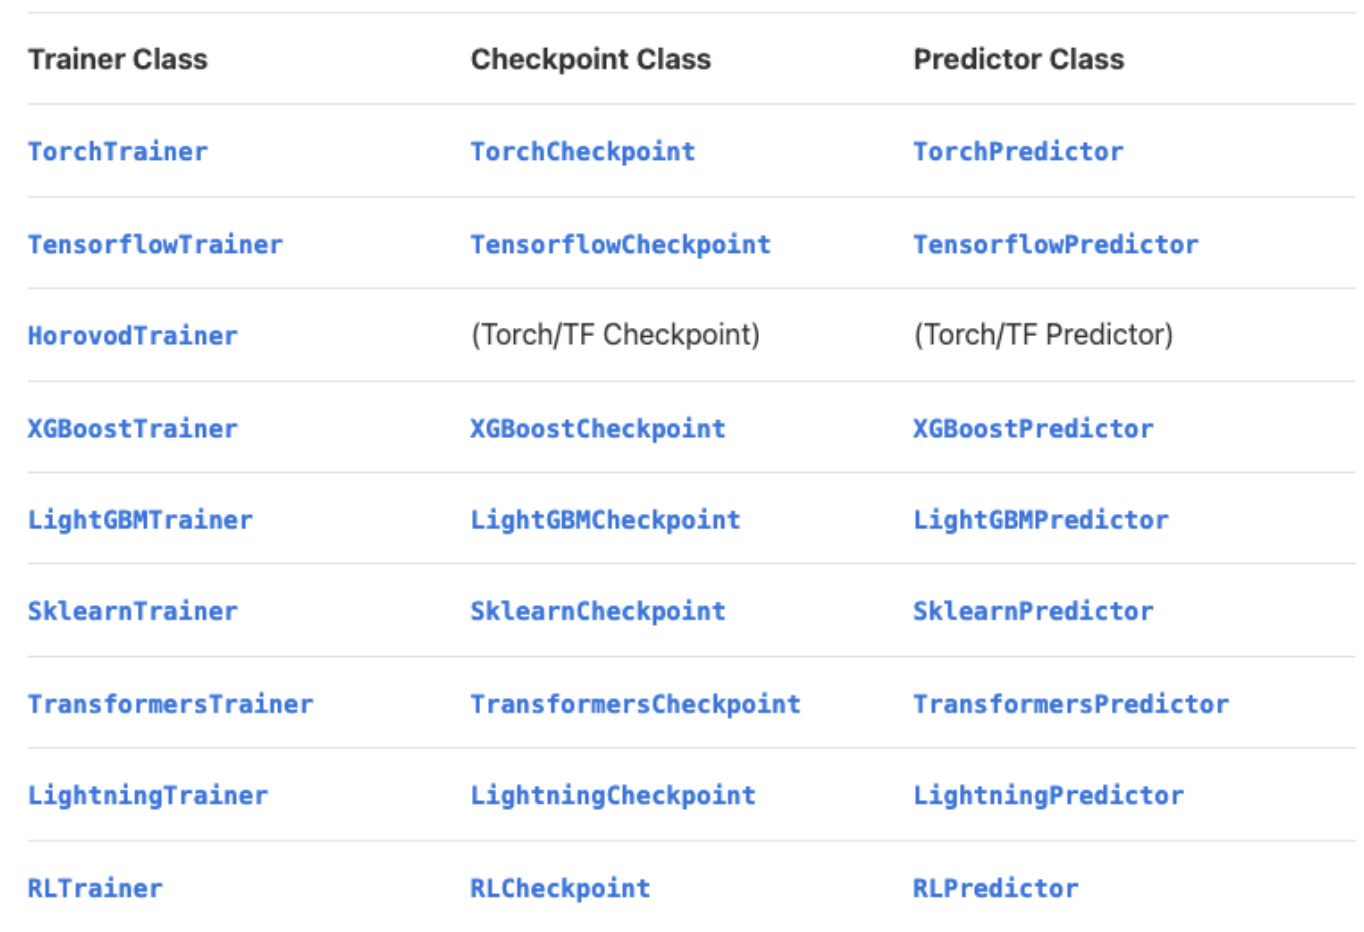

In [58]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    #preprocessor=preprocessor,
)

2023-12-19 09:16:22,750	WARNING data_parallel_trainer.py:283 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.


In [59]:
# Train
results = trainer.fit()

(TorchTrainer pid=34193) The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
(TorchTrainer pid=34193) Starting distributed worker processes: ['34199 (127.0.0.1)', '34200 (127.0.0.1)', '34201 (127.0.0.1)', '34202 (127.0.0.1)', '34203 (127.0.0.1)', '34204 (127.0.0.1)']
(RayTrainWorker pid=34199) Setting up process group for: env:// [rank=0, world_size=6]
(RayTrainWorker pid=34200) [W ProcessGroupGloo.cpp:725] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=34200) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.pred

ValueError: No experiment checkpoint file of form 'experiment_state-*.json' was found at: (local, /Users/sguys99/ray_results/llm)
Please check if you specified the correct experiment path, which should be a combination of the `storage_path` and `name` specified in your run.

In [51]:
results

NameError: name 'results' is not defined

--- 다시 해볼 것